Gensim is a Python library for unsupervised topic modeling, document similarity analysis, and vector space modeling in natural language processing. It efficiently handles large text corpora using streaming and incremental algorithms.

**Key features include:**
- Pre-trained Models: It supports loading pre-trained models like Google News Word2Vec (trained on 3 billion words) and embeddings from Twitter corpora, which help in analyzing different text domains. These models capture semantic relationships between words (e.g., "king - man + woman ≈ queen").

- Built-in implementations of Word2Vec, FastText, Latent Dirichlet Allocation( LDA), and Latent Semantic Analysis (LSA).

- Built on NumPy and SciPy, leveraging optimized mathematical operations.


In [ ]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
wv.similarity(w1="great", w2="good")

0.729151

In [ ]:
wv_great = wv["great"]
wv_good = wv["good"]

In [ ]:
wv_great.shape, wv_good.shape

((300,), (300,))

In [ ]:
wv.most_similar("good")

[('great', 0.7291510105133057),
 ('bad', 0.7190051078796387),
 ('terrific', 0.6889115571975708),
 ('decent', 0.6837348341941833),
 ('nice', 0.6836092472076416),
 ('excellent', 0.644292950630188),
 ('fantastic', 0.6407778263092041),
 ('better', 0.6120728850364685),
 ('solid', 0.5806034803390503),
 ('lousy', 0.576420247554779)]

In [ ]:
wv.doesnt_match(["facebook", "cat", "google", "microsoft"])

'cat'

In [ ]:
wv.most_similar(positive=['king', 'woman'], negative=['man'])

[('queen', 0.7118193507194519),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321839332581),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593831062317),
 ('monarchy', 0.5087411999702454)]

In [ ]:
wv.most_similar(positive=['france', 'berlin'], negative=['paris'], topn=5)

[('germany', 0.5094343423843384),
 ('european', 0.48650455474853516),
 ('german', 0.4714890420436859),
 ('austria', 0.46964022517204285),
 ('swedish', 0.4645182490348816)]

#Fake vs Real News Classification Using This Word2Vec Embeddings

- We are going to address these problems using classical NLP techniques and going to classify whether a given message/ text is **Real or Fake Message.**

- We will use **glove embeddings** from spacy which is trained on massive wikipedia dataset to pre-process and text vectorization and apply different classification algorithms.



---

**Dataset**

Credits: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

- This data consists of two columns. - Text - label

- As there are only 2 classes, this problem comes under the Binary Classification.

In [ ]:
import pandas as pd

df = pd.read_csv('/content/fake_and_real_news.csv')

df.shape

(9900, 2)

In [ ]:
df.head()

,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake
1,U.S. conservative leader optimistic of common ...,Real
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real
3,Court Forces Ohio To Allow Millions Of Illega...,Fake
4,Democrats say Trump agrees to work on immigrat...,Real


In [ ]:
df['label'].value_counts()

,count
label,
Fake,5000
Real,4900


This dataset is balanced both classes have almost same number of samples so we don't need to apply any balanced technique such as oversampling (SMOTE), undersampling etc.

In [ ]:
df['label_num'] = df['label'].map({
    'Fake': 0,
    'Real': 1
})

df.head()

,Text,label,label_num
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,0
1,U.S. conservative leader optimistic of common ...,Real,1
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,1
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,0
4,Democrats say Trump agrees to work on immigrat...,Real,1


#Pre-Processing

**Now we will convert the text into a vector using gensim's word2vec embeddings.**
1. Preprocess the text to remove stopping words, punctuations and get lemma for each word.
2. Get word vectors for each of the words in a pre-processed sentence
3. Take a mean of all word vectors to derive the numeric representation of the entire news article.

In [ ]:
wv_good[:5]

array([ 0.04052734,  0.0625    , -0.01745605,  0.07861328,  0.03271484],
      dtype=float32)

In [ ]:
wv_great[:5]

array([ 0.07177734,  0.20800781, -0.02844238,  0.17871094,  0.1328125 ],
      dtype=float32)

In [ ]:
import numpy as np
r1 = np.mean([wv_good, wv_great], axis=0)
r1[:5]

array([ 0.05615234,  0.1352539 , -0.02294922,  0.12866211,  0.08276367],
      dtype=float32)

In [ ]:
r2 = wv.get_mean_vector(["good", "great"], pre_normalize=False)
r2[:5]

array([ 0.05615234,  0.1352539 , -0.02294922,  0.12866211,  0.08276367],
      dtype=float32)

In [ ]:
#i'm running this code at colab so i need to download library
!python -m spacy download en_core_web_lg

In [ ]:
import spacy
nlp = spacy.load('en_core_web_lg')

def preprocessing_and_vectorize(text):
  doc = nlp(text)
  filtered_tokens = []

  for token in doc:
    if token.is_stop or token.is_punct:
      continue
    filtered_tokens.append(token.lemma_)

  return wv.get_mean_vector(filtered_tokens)


/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [ ]:
df['vector'] = df['Text'].apply(lambda x: preprocessing_and_vectorize(x))

#Splitting Dataset

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['vector'].values, df['label_num'], test_size=0.2, random_state=42, stratify=df['label_num'])

Reshaping the X_train and X_test so as to fit for models

In [ ]:
print("Shape of X_train before reshaping: ", X_train.shape)
print("Shape of X_test before reshaping: ", X_test.shape)

X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

print("Shape of X_train after reshaping: ", X_train_2d.shape)
print("Shape of X_test after reshaping: ", X_test_2d.shape)

Shape of X_train before reshaping:  (7920,)
Shape of X_test before reshaping:  (1980,)
Shape of X_train after reshaping:  (7920, 300)
Shape of X_test after reshaping:  (1980, 300)


#Model Training

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

clf = DecisionTreeClassifier()

clf.fit(X_train_2d, y_train)

y_pred = clf.predict(X_test_2d)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1000
           1       0.92      0.91      0.91       980

    accuracy                           0.91      1980
   macro avg       0.91      0.91      0.91      1980
weighted avg       0.91      0.91      0.91      1980



In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

clf.fit(X_train_2d, y_train)

y_pred = clf.predict(X_test_2d)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1000
           1       0.97      0.97      0.97       980

    accuracy                           0.97      1980
   macro avg       0.97      0.97      0.97      1980
weighted avg       0.97      0.97      0.97      1980



In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_2d)
X_test_scaled = scaler.transform(X_test_2d)

clf = MultinomialNB()

clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1000
           1       0.94      0.94      0.94       980

    accuracy                           0.94      1980
   macro avg       0.94      0.94      0.94      1980
weighted avg       0.94      0.94      0.94      1980



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()

clf.fit(X_train_2d, y_train)

y_pred = clf.predict(X_test_2d)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1000
           1       0.98      0.98      0.98       980

    accuracy                           0.98      1980
   macro avg       0.98      0.98      0.98      1980
weighted avg       0.98      0.98      0.98      1980



#Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
cm

array([[979,  21],
       [ 16, 964]])

Text(45.722222222222214, 0.5, 'Truth')

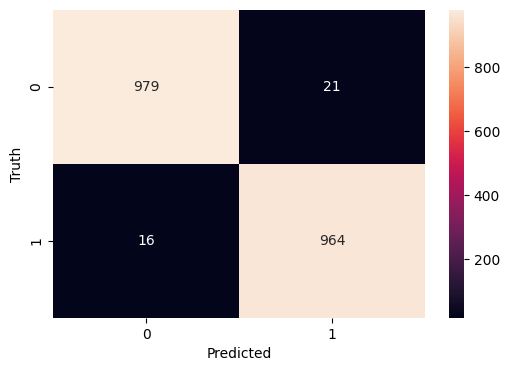

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

Making some predictions

In [ ]:
test_news = [
    "Michigan governor denies misleading U.S. House on Flint water (Reuters) - Michigan Governor Rick Snyder denied Thursday that he had misled a U.S. House of Representatives committee last year over testimony on Flintâ€™s water crisis after lawmakers asked if his testimony had been contradicted by a witness in a court hearing. The House Oversight and Government Reform Committee wrote Snyder earlier Thursday asking him about published reports that one of his aides, Harvey Hollins, testified in a court hearing last week in Michigan that he had notified Snyder of an outbreak of Legionnairesâ€™ disease linked to the Flint water crisis in December 2015, rather than 2016 as Snyder had testified. â€œMy testimony was truthful and I stand by it,â€ Snyder told the committee in a letter, adding that his office has provided tens of thousands of pages of records to the committee and would continue to cooperate fully.  Last week, prosecutors in Michigan said Dr. Eden Wells, the stateâ€™s chief medical executive who already faced lesser charges, would become the sixth current or former official to face involuntary manslaughter charges in connection with the crisis. The charges stem from more than 80 cases of Legionnairesâ€™ disease and at least 12 deaths that were believed to be linked to the water in Flint after the city switched its source from Lake Huron to the Flint River in April 2014. Wells was among six current and former Michigan and Flint officials charged in June. The other five, including Michigan Health and Human Services Director Nick Lyon, were charged at the time with involuntary manslaughter",
    " WATCH: Fox News Host Loses Her Sh*t, Says Investigating Russia For Hacking Our Election Is Unpatriotic This woman is insane.In an incredibly disrespectful rant against President Obama and anyone else who supports investigating Russian interference in our election, Fox News host Jeanine Pirro said that anybody who is against Donald Trump is anti-American. Look, it s time to take sides,  she began.",
    " Sarah Palin Celebrates After White Man Who Pulled Gun On Black Protesters Goes Unpunished (VIDEO) Sarah Palin, one of the nigh-innumerable  deplorables  in Donald Trump s  basket,  almost outdid herself in terms of horribleness on Friday."
]

test_news_vectors = [preprocessing_and_vectorize(n) for n in test_news]
clf.predict(test_news_vectors)

array([1, 0, 0])